In [12]:
import pandas as pd
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import IPython.display as ipd
import librosa as lib
import librosa.display
import wave

In [2]:
set_a_load="/content/drive/MyDrive/archive/set_a.csv"

In [3]:
set_a=pd.read_csv(set_a_load)

In [4]:
set_a.head()

,dataset,fname,label,sublabel
0,a,set_a/artifact__201012172012.wav,artifact,NaN
1,a,set_a/artifact__201105040918.wav,artifact,NaN
2,a,set_a/artifact__201105041959.wav,artifact,NaN
3,a,set_a/artifact__201105051017.wav,artifact,NaN
4,a,set_a/artifact__201105060108.wav,artifact,NaN


In [5]:
filtered_set_a = set_a[set_a['label'].isin(['murmur', 'normal'])].copy()
filtered_set_a['label'] = filtered_set_a['label'].replace('normal', 'non murmur')
filtered_set_a=filtered_set_a[['fname', 'label']]
filtered_set_a

,fname,label
59,set_a/murmur__201101051104.wav,murmur
60,set_a/murmur__201101051108.wav,murmur
61,set_a/murmur__201101051114.wav,murmur
62,set_a/murmur__201101180902.wav,murmur
63,set_a/murmur__201102051443.wav,murmur
...,...,...
119,set_a/normal__201106221450.wav,non murmur
120,set_a/normal__201108011112.wav,non murmur
121,set_a/normal__201108011114.wav,non murmur
122,set_a/normal__201108011115.wav,non murmur


In [6]:
filtered_set_a.groupby(['label']).count()

,fname
label,
murmur,34
non murmur,31


In [13]:
ipd.Audio(r"/content/drive/MyDrive/archive/set_b/normal__177_1307989650056_D1.wav")

In [9]:
import wave

In [10]:
wav=wave.open(r'/content/drive/MyDrive/archive/set_a/normal__201106111136.wav')
framerate=wav.getframerate()
print(framerate)
framesize=wav.getnframes()
print(framesize)
duration = framesize / framerate
print(duration)

44100
218903
4.963786848072562


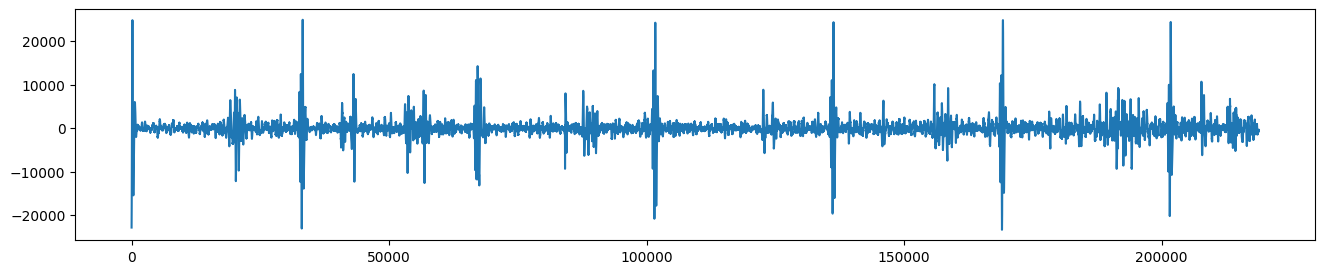

In [11]:
from scipy.io import wavfile
rate,data=wavfile.read(r'/content/drive/MyDrive/archive/set_a/normal__201106111136.wav')
plt.figure(figsize=(16, 3))
plt.plot(data,'-',)
plt.show()

Original sample rate: 22050
Resampled sample rate: 16000
Original audio shape: (195894,)
Resampled audio shape: (142146,)


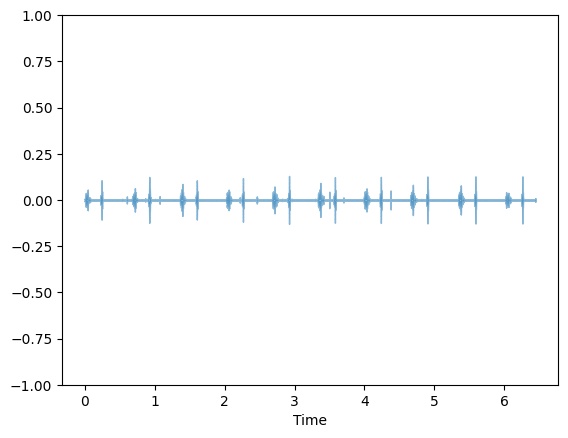

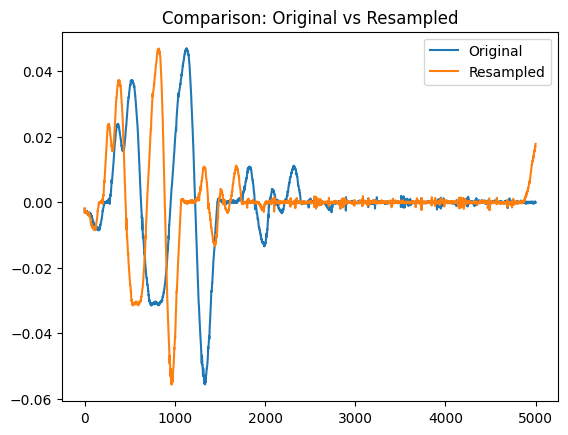

In [16]:
audio, original_sr = lib.load(r'/content/drive/MyDrive/archive/set_a/murmur__201101051108.wav')

# Resample the audio to 16000 Hz
target_sr = 16000
resampled_audio = lib.resample(audio, orig_sr=original_sr, target_sr=target_sr)

print(f"Original sample rate: {original_sr}")
print(f"Resampled sample rate: {target_sr}")
print(f"Original audio shape: {audio.shape}")
print(f"Resampled audio shape: {resampled_audio.shape}")
librosa.display.waveshow(resampled_audio,alpha=0.5)
plt.ylim(-1,1)
plt.show()
plt.plot(audio[:5000], label='Original')
plt.plot(resampled_audio[:5000], label='Resampled')
plt.legend()
plt.title("Comparison: Original vs Resampled")
plt.show()

Number of samples=sampling Rate(Hz)*Duration(seconds)

frame=⌊(no_of sample-frame_length/frame step)⌋+1

freq_bins=frame_length//2+1

avd duration of clips=4.3sec

no_sample=4.3*16000=68800samples

Use common window values (standard for speech/audio):

frame length = 25 ms 0.025 × 16000 = 400 samples

frame step = 10 ms 0.010 × 16000 = 160 samples


In [17]:
def extract_logmel(file_path):
  target_sr=16000
  audio, sr = librosa.load(file_path)
  resampled_audio = lib.resample(audio, orig_sr=original_sr, target_sr=target_sr)
  S = librosa.feature.melspectrogram(y=resampled_audio, n_mels=128, fmax=8000)
  log_mel = librosa.power_to_db(S, ref=np.max)
  if log_mel.shape[1] < 400:
        pad_width = 400 - log_mel.shape[1]
        log_mel = np.pad(log_mel, ((0, 0), (0, pad_width)), mode='constant')
  else:
      log_mel = log_mel[:, :400]
  return log_mel

In [18]:
LABEL_MAP = {'non murmur': 0, 'murmur': 1}
X=[]
y=[]
for index, row in filtered_set_a.iterrows():
    #print(f"Processing file: {row['fname']},{row['label']}")
    file_path = f"/content/drive/MyDrive/archive/{row['fname']}"
    logmel=extract_logmel(file_path)
    X.append(logmel[..., np.newaxis])#
    y.append(LABEL_MAP[row['label']])
X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=np.int64)
print(X.shape)
print(y.shape)

(65, 128, 400, 1)
(65,)


In [19]:
np.save('/content/sample_data/X.npy',X)
np.save('/content/sample_data/y.npy',y)

# LeNet5 Architecture

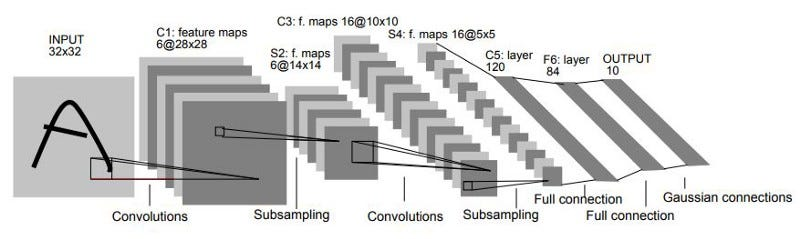

In [45]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

class LeNet5(nn.Module):
  def __init__(self,num_classes=2):
    super(LeNet5,self).__init__()

    self.conv1=nn.Conv2d(in_channels=1,out_channels=6,kernel_size=5)
    self.pool1=nn.AvgPool2d(kernel_size=2,stride=2)

    self.conv2=nn.Conv2d(in_channels=6,out_channels=16,kernel_size=5)
    self.pool2=nn.AvgPool2d(kernel_size=2,stride=2)

    self.conv3=nn.Conv2d(in_channels=16,out_channels=120,kernel_size=5)

    self.fc1=nn.Linear(in_features=120 * 25 * 93,out_features=84)
    self.fc2=nn.Linear(in_features=84,out_features=num_classes)

  def forward(self,x):
    out=F.relu(self.conv1(x))
    out=self.pool1(out)

    out=F.relu(self.conv2(out))
    out=self.pool2(out)

    out=F.relu(self.conv3(out))

    out=out.reshape(out.size(0),-1)

    out=F.relu(self.fc1(out))
    out=self.fc2(out)
    return out

In [22]:
X=np.load('/content/sample_data/X.npy')
y=np.load('/content/sample_data/y.npy')

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [25]:
#normalization
X = X.astype(np.float32)
for i in range(X.shape[0]):
    max_val = np.max(X[i])
    if max_val > 0:
        X[i] = X[i] / max_val

X = np.transpose(X, (0, 3, 1, 2))

In [26]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.long)

batch_size = 32
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size)


In [65]:
# Model, Loss, Optimizer
model = LeNet5().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.001)

Epoch [1/15], Loss: 109.9776, Accuracy: 40.38%
Epoch [2/15], Loss: 31.3490, Accuracy: 53.85%
Epoch [3/15], Loss: 15.9691, Accuracy: 48.08%
Epoch [4/15], Loss: 1.3509, Accuracy: 73.08%
Epoch [5/15], Loss: 1.0982, Accuracy: 71.15%
Epoch [6/15], Loss: 1.2902, Accuracy: 75.00%
Epoch [7/15], Loss: 0.8943, Accuracy: 78.85%
Epoch [8/15], Loss: 0.8669, Accuracy: 82.69%
Epoch [9/15], Loss: 0.7109, Accuracy: 84.62%
Epoch [10/15], Loss: 0.6841, Accuracy: 86.54%
Epoch [11/15], Loss: 0.5498, Accuracy: 86.54%
Epoch [12/15], Loss: 0.4346, Accuracy: 92.31%
Epoch [13/15], Loss: 0.2712, Accuracy: 96.15%
Epoch [14/15], Loss: 0.6947, Accuracy: 86.54%
Epoch [15/15], Loss: 0.2357, Accuracy: 96.15%


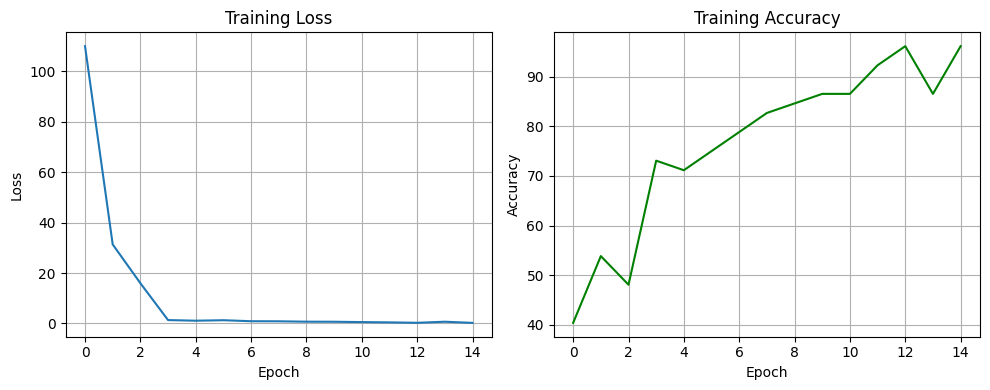

In [66]:
num_epochs = 15
train_losses = []
train_accuracies = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

    acc = 100 * correct / total
    train_losses.append(total_loss)
    train_accuracies.append(acc)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss:.4f}, Accuracy: {acc:.2f}%")
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train Accuracy", color='green')
plt.title("Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid()

plt.tight_layout()
plt.show()

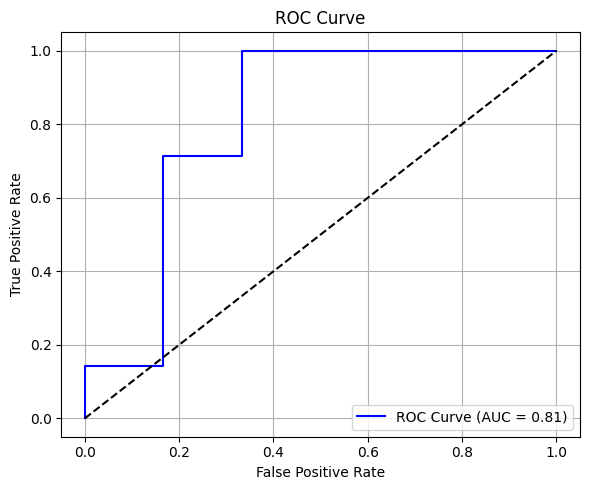


Sensitivity (Recall): 1.0000
Specificity         : 0.6667

Confusion Matrix:
 [[4 2]
 [0 7]]

Classification Report:
               precision    recall  f1-score   support

  non murmur       1.00      0.67      0.80         6
      murmur       0.78      1.00      0.88         7

    accuracy                           0.85        13
   macro avg       0.89      0.83      0.84        13
weighted avg       0.88      0.85      0.84        13



In [160]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import confusion_matrix, recall_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
model.eval()
all_preds = []
all_probs = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())  # ✅ only this line for labels

        probs = F.softmax(outputs, dim=1)[:, 1]   # Prob of class 1
        all_probs.extend(probs.cpu().numpy())

# Convert to numpy arrays
all_probs = np.array(all_probs)
all_labels = np.array(all_labels)

# ROC and AUC
fpr, tpr, _ = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})', color='blue')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

# 9. Metrics
cm = confusion_matrix(all_labels, all_preds)
report = classification_report(all_labels, all_preds, target_names=['non murmur', 'murmur'])
TN, FP, FN, TP = cm.ravel()

sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0.0  # also recall
specificity = TN / (TN + FP) if (TN + FP) > 0 else 0.0  # true negative rate

print(f"\nSensitivity (Recall): {sensitivity:.4f}")
print(f"Specificity         : {specificity:.4f}")

print("\nConfusion Matrix:\n", cm)
print("\nClassification Report:\n", report)

# Lenet1 Architecture

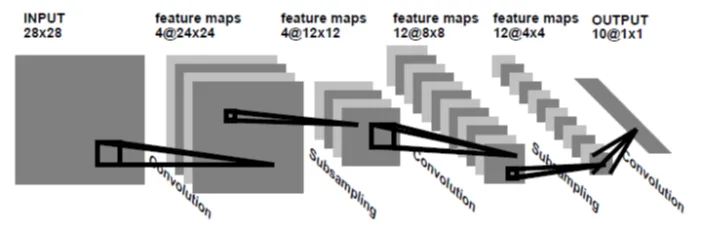

In [78]:
class LeNet1(nn.Module):
    def __init__(self, num_classes=2, dropout_rate=0.3):
        super(LeNet1, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=5)  # (4, 124, 396)
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)                    # (4, 62, 198)
        self.dropout1 = nn.Dropout(dropout_rate)                              # Dropout after pooling

        self.fc1 = nn.Linear(4 * 62 * 198, 84)
        self.dropout2 = nn.Dropout(dropout_rate)                              # Dropout after FC1
        self.fc2 = nn.Linear(84, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = self.dropout1(x)  # Dropout after conv-pool

        x = x.view(x.size(0), -1)  # Flatten

        x = F.relu(self.fc1(x))
        x = self.dropout2(x)      # Dropout after FC
        x = self.fc2(x)
        return x

In [161]:
X=np.load('/content/sample_data/X.npy')
y=np.load('/content/sample_data/y.npy')

In [162]:
X = X.astype(np.float32)
for i in range(X.shape[0]):
    max_val = np.max(X[i])
    if max_val > 0:
        X[i] = X[i] / max_val

X = np.transpose(X, (0, 3, 1, 2))

In [163]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train = torch.tensor(X_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_val = torch.tensor(y_val, dtype=torch.long)

train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

In [164]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LeNet1(num_classes=2).to(device)

# 6. Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.0005, weight_decay=1e-5)

Epoch [1/20], Loss: 24.9823, Accuracy: 59.62%
Epoch [2/20], Loss: 27.5478, Accuracy: 55.77%
Epoch [3/20], Loss: 11.9321, Accuracy: 71.15%
Epoch [4/20], Loss: 10.9696, Accuracy: 69.23%
Epoch [5/20], Loss: 11.7226, Accuracy: 61.54%
Epoch [6/20], Loss: 7.9130, Accuracy: 71.15%
Epoch [7/20], Loss: 6.3132, Accuracy: 76.92%
Epoch [8/20], Loss: 5.7016, Accuracy: 75.00%
Epoch [9/20], Loss: 3.8922, Accuracy: 80.77%
Epoch [10/20], Loss: 3.0686, Accuracy: 80.77%
Epoch [11/20], Loss: 4.0937, Accuracy: 82.69%
Epoch [12/20], Loss: 2.1428, Accuracy: 86.54%
Epoch [13/20], Loss: 1.7803, Accuracy: 88.46%
Epoch [14/20], Loss: 0.8273, Accuracy: 86.54%
Epoch [15/20], Loss: 0.3140, Accuracy: 94.23%
Epoch [16/20], Loss: 0.3967, Accuracy: 90.38%
Epoch [17/20], Loss: 0.6869, Accuracy: 86.54%
Epoch [18/20], Loss: 0.2364, Accuracy: 98.08%
Epoch [19/20], Loss: 0.4337, Accuracy: 92.31%
Epoch [20/20], Loss: 0.2046, Accuracy: 94.23%


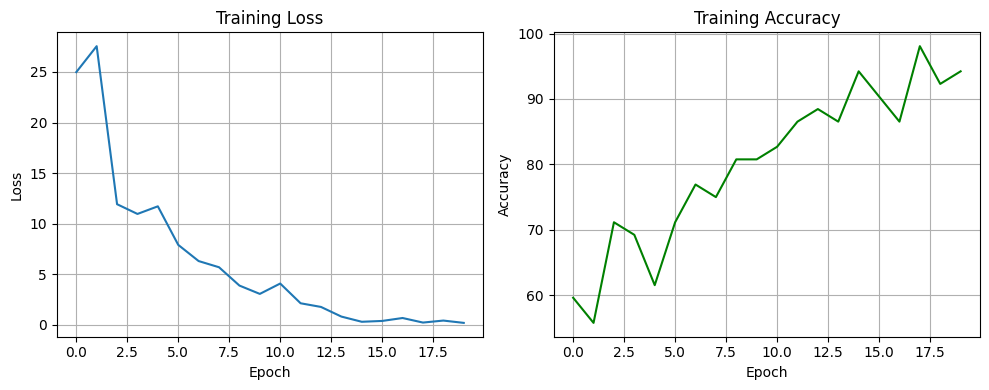

In [166]:
num_epochs = 20
train_losses = []
train_accuracies = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

    acc = 100 * correct / total
    train_losses.append(total_loss)
    train_accuracies.append(acc)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss:.4f}, Accuracy: {acc:.2f}%")

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train Accuracy", color='green')
plt.title("Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid()

plt.tight_layout()
plt.show()

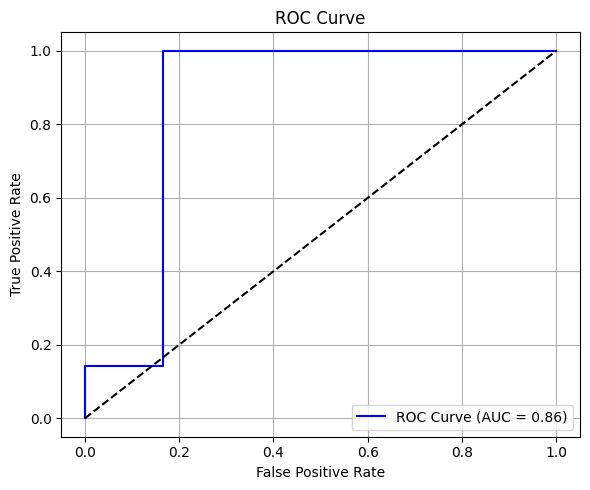


Sensitivity (Recall): 1.0000
Specificity         : 0.6667

 Confusion Matrix:
 [[4 2]
 [0 7]]

Classification Report:
               precision    recall  f1-score   support

  non murmur       1.00      0.67      0.80         6
      murmur       0.78      1.00      0.88         7

    accuracy                           0.85        13
   macro avg       0.89      0.83      0.84        13
weighted avg       0.88      0.85      0.84        13



In [167]:
# 8. Evaluation on validation set
from sklearn.metrics import roc_curve, auc, roc_auc_score

model.eval()
all_preds = []
all_probs = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())  # ✅ only this line for labels

        probs = F.softmax(outputs, dim=1)[:, 1]   # Prob of class 1
        all_probs.extend(probs.cpu().numpy())

# Convert to numpy arrays
all_probs = np.array(all_probs)
all_labels = np.array(all_labels)

# ROC and AUC
fpr, tpr, _ = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})', color='blue')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()
# 9. Metrics
cm = confusion_matrix(all_labels, all_preds)
report = classification_report(all_labels, all_preds, target_names=['non murmur', 'murmur'])
TN, FP, FN, TP = cm.ravel()

sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0.0  # also recall
specificity = TN / (TN + FP) if (TN + FP) > 0 else 0.0  # true negative rate

print(f"\nSensitivity (Recall): {sensitivity:.4f}")
print(f"Specificity         : {specificity:.4f}")

print("\n Confusion Matrix:\n", cm)
print("\nClassification Report:\n", report)